In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc 
import tqdm

% matplotlib inline

In [2]:
# Obtain all labels
response = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=[0, 969])
df = pd.read_csv('data/train_date.csv.zip', index_col=0)
df = df.join(response)

/home/li/miniconda3/envs/kaggle/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
n_parts, n_columns = df.shape
n_columns -= 1
print(n_parts, n_columns)

1183747 1156


In [8]:
# stations and features in each station
stations = list(set([f.split('_')[1] for f in df.columns.tolist() if f!='Response']))

station_features = {s: [f for f in df.columns.tolist() if s in f] for s in stations }

In [22]:
# Calculate samples in each feature, if there is any station that every or almost every part flows by?
columns = df.columns.tolist()
feature_samples = {}
for col in tqdm.tqdm(columns):
    feature_samples[col] = len(df.loc[df[col].notna(), col])

feature_samples = pd.Series(feature_samples)
feature_samples.sort_values(ascending=False, inplace=True)
feature_samples.drop('Response', inplace=True)

100%|██████████| 1157/1157 [00:03<00:00, 322.43it/s]


In [26]:
print(feature_samples.max()/n_parts)

0.9464809625705493


In [40]:
s = {}
p = {}
station
for i, n in enumerate(feature_samples.unique()):
    s[i] = (n, feature_samples.loc[feature_samples==n].index.tolist())
    p[i] = (n, list(set([k.split('_')[1] for k in s[i][1]])))

### The number of segments in production
Productions with 3 segments or more tends to have different error distributions.

In [81]:
def segments(part_in, threshold=0.05):
    '''Calculate number of segments in a part.'''
    part_in.dropna(inplace=True)
    part_in.drop('Response', inplace=True)
    return sum(part_in.diff().fillna(0)>threshold) + 1

In [85]:
df['segment'] = df.apply(segments, axis=1)

Parts with 2 segments have slightly lower error rate (0.005 vs 0.0058 on average), 3 and 4 segments are slightly higher. 5-segments parts are significantly higher than average (0.013 vs 0.0058 on average).

In [90]:
a = df.groupby('segment').Response.agg(['mean', 'sum', 'count'])
a['confidence'] = 1.96 * np.sqrt(a['mean'] * (1 - a['mean']) / a['count'])
a['mean_plus'] = a['mean'] + a['confidence']
a['mean_minus'] = a['mean'] - a['confidence']
a

,mean,sum,count,confidence,mean_plus,mean_minus
segment,,,,,,
1,0.008777,29,3304,0.003181,0.011958,0.005597
2,0.004755,3424,720021,0.000159,0.004914,0.004597
3,0.007156,2518,351889,0.000278,0.007434,0.006877
4,0.007604,749,98495,0.000543,0.008147,0.007062
5,0.015485,142,9170,0.002527,0.018012,0.012958
6,0.017060,13,762,0.009195,0.026255,0.007866
7,0.031579,3,95,0.035166,0.066745,-0.003587
8,0.100000,1,10,0.185942,0.285942,-0.085942
9,0.000000,0,1,0.000000,0.000000,0.000000


In [97]:
b = df.groupby(['Response', 'segment']).Response.agg(['mean', 'sum', 'count'])
b.reset_index(level=1, inplace=True)
b

,segment,mean,sum,count
Response,,,,
0,1,0,0,3275
0,2,0,0,716597
0,3,0,0,349371
0,4,0,0,97746
0,5,0,0,9028
0,6,0,0,749
0,7,0,0,92
0,8,0,0,9
0,9,0,0,1


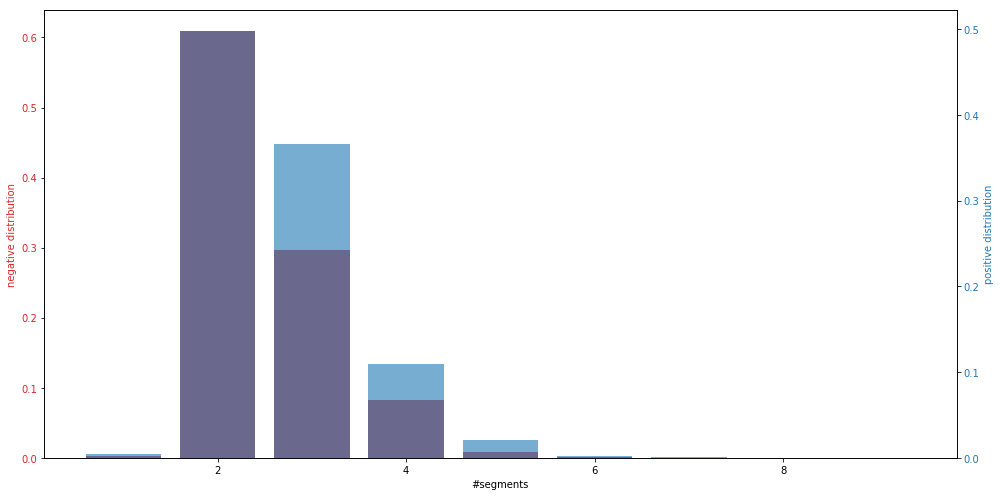

In [105]:
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('#segments')
ax1.set_ylabel('negative distribution', color=color)
#ax1.set_xlim([-0.5, Nxlim+0.5])
#xticks = ['{:.1f}'.format(tmp) for tmp in ax1.get_xticks() * tbin + 0.5 * tbin]
#ax1.set_xticklabels(xticks)
ax1.bar(b.loc[0, 'segment'], b.loc[0, 'count']/b.loc[0, 'count'].sum(), alpha=0.8, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('positive distribution', color=color)  # we already handled the x-label with ax1
ax2.bar(b.loc[1, 'segment'], b.loc[1, 'count']/b.loc[1, 'count'].sum(), alpha=0.6, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Order of productions on each station or feature

In [100]:
df.columns

Index(['L0_S0_D1', 'L0_S0_D3', 'L0_S0_D5', 'L0_S0_D7', 'L0_S0_D9', 'L0_S0_D11',
       'L0_S0_D13', 'L0_S0_D15', 'L0_S0_D17', 'L0_S0_D19',
       ...
       'L3_S50_D4250', 'L3_S50_D4252', 'L3_S50_D4254', 'L3_S51_D4255',
       'L3_S51_D4257', 'L3_S51_D4259', 'L3_S51_D4261', 'L3_S51_D4263',
       'Response', 'segment'],
      dtype='object', length=1158)

Randomly pick one column `L3_S50_D4252`

In [122]:
x = df.loc[df['L3_S50_D4252'].notna(), ['L3_S50_D4252', 'Response']].copy()
x.reset_index(inplace=True)
x.reset_index(inplace=True)

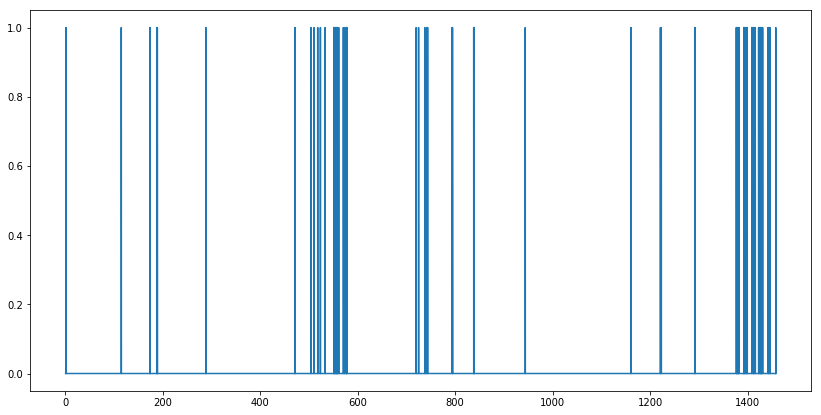

In [112]:
x.sort_values('L3_S50_D4252', ascending=True, inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(x['L3_S50_D4252'], x['Response'])

Errors are not uniformly distributed in time. Calculate the distance to the nearest error on two sides.

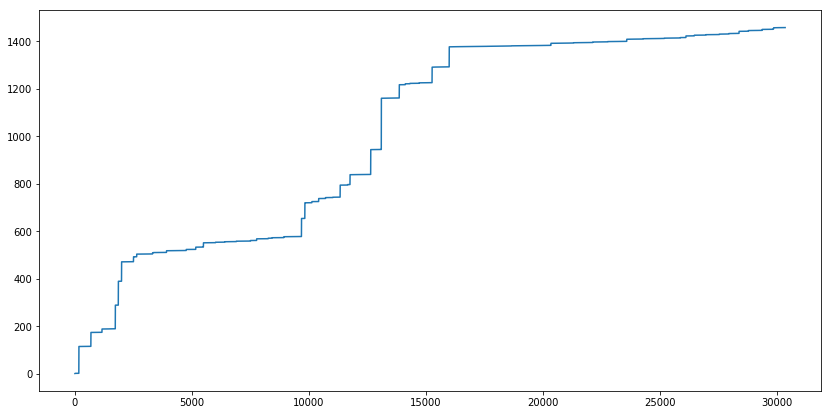

In [118]:
x.sort_values(['L3_S50_D4252', 'Id'], ascending=True, inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(x['L3_S50_D4252'].values)

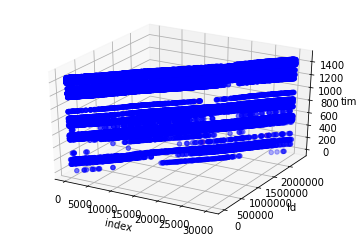

In [130]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
#   xs = randrange(n, 23, 32)
#   ys = randrange(n, 0, 100)
#   zs = randrange(n, zlow, zhigh)
#   ax.scatter(xs, ys, zs, c=c, marker=m)

ax.scatter(x.loc[x.Response==0, 'index'], x.loc[x.Response==0, 'Id'], x.loc[x.Response==0, 'L3_S50_D4252'], c='b')
ax.scatter(x.loc[x.Response==1, 'index'], x.loc[x.Response==1, 'Id'], x.loc[x.Response==1, 'L3_S50_D4252'], c='r')

ax.set_xlabel('index')
ax.set_ylabel('Id')
ax.set_zlabel('time')

plt.show()

Each part is determined by index after sorting, ID, and time. Plotting these 3d tuples in 3d space, find that ID and index are equivalent. Since ID is more general in testing set, index will not be used.

In [133]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

trace1 = go.Scatter3d(
    x=x.loc[x.Response==0, 'index'], 
    y=x.loc[x.Response==0, 'Id'], 
    z=x.loc[x.Response==0, 'L3_S50_D4252'],
    mode='markers',
    marker=dict(
        size=0.5,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

trace2 = go.Scatter3d(
    x=x.loc[x.Response==1, 'index'], 
    y=x.loc[x.Response==1, 'Id'], 
    z=x.loc[x.Response==1, 'L3_S50_D4252'],
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=2,
        symbol='circle',
        line=dict(
            color='rgb(255, 0, 0)',
            width=1
        ),
        opacity=0.9
    )
)
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')


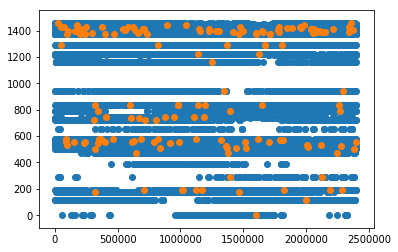

In [138]:
plt.scatter(x=x.loc[x.Response==0, 'index']+ x.loc[x.Response==0, 'Id'], y=x.loc[x.Response==0, 'L3_S50_D4252'])
plt.scatter(x=x.loc[x.Response==1, 'index']+ x.loc[x.Response==1, 'Id'], y=x.loc[x.Response==1, 'L3_S50_D4252'])

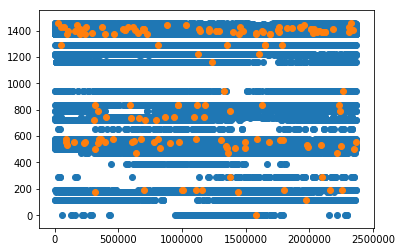

In [140]:
plt.scatter(x=x.loc[x.Response==0, 'Id'], y=x.loc[x.Response==0, 'L3_S50_D4252'])
plt.scatter(x=x.loc[x.Response==1, 'Id'], y=x.loc[x.Response==1, 'L3_S50_D4252'])